Boundary Reset
===============

This example demonstrates how to use the "reset" boundary condition to simulate convection through a channel. In reset conditions, the initial concentration of a species is restored for a particle that crosses a reseting boundary. 

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/tjsego/mechanica-binder/HEAD?filepath=notebooks%2Fboundary_reset.ipynb)

Basic Setup
------------

Initialize Mechanica for flow through a channel along the ``x``-direction with reset conditions. 

In [1]:
import mechanica as mx

# Initialize a domain like a tunnel, with flow along the x-direction
mx.init(dim=[20, 10, 10],
        cells=[5, 5, 5],
        cutoff=5,
        bc={'x': ('periodic', 'reset'), 'y': 'free_slip', 'z': 'free_slip'})

Particle  Types
----------------

Create two particle types, 

1. one to represent parcels of fluid materials carrying a concentration of a species with entry concentration of ``1.0``, and 
2. one to act like a flow barrier and concentration sink, with constant species concentration of ``0.0``. 

In [2]:
class CarrierType(mx.ParticleType):
    """A particle type to carry stuff"""

    radius = 0.5
    mass = 0.1
    species = ['S1']
    style = {'colormap': {'species': 'S1', range: (0, 1)}}


class SinkType(mx.ParticleType):
    """A particle type to absorb stuff"""

    frozen = True
    radius = 1.0
    species = ['S1']
    style = {'colormap': {'species': 'S1', range: (0, 1)}}


carrier_type, sink_type = CarrierType.get(), SinkType.get()

carrier_type.species.S1.initial_concentration = 1.0
sink_type.species.S1.constant = True

Fluid Interactions
-------------------

Construct fluid interactions for the following cases. 

1. Fluid particles in the domain interact according to dissipative particle dynamics (DPD). 
2. Sink particles act like a barrier for fluid flow. 

In [3]:
# Carrier type like a fluid
dpd = mx.Potential.dpd(alpha=1, gamma=1, sigma=0.1, cutoff=3 * CarrierType.radius)
mx.bind.types(dpd, carrier_type, carrier_type)

# Sink type like a barrier
rep = cp = mx.Potential.harmonic(k=1000,
                                 r0=carrier_type.radius + 1.05 * sink_type.radius,
                                 min=carrier_type.radius + sink_type.radius,
                                 max=carrier_type.radius + 1.05 * sink_type.radius,
                                 tol=0.001)
mx.bind.types(rep, carrier_type, sink_type)

0

Convection
-----------

Apply a constant force to drive fluid flow towards ``+x``, and diffusive transport between fluid particles and, at a faster rate, between fluid and sink particles. 

In [4]:
force = mx.ConstantForce([0.01, 0, 0])
mx.bind.force(force, carrier_type)

mx.Fluxes.flux(carrier_type, carrier_type, "S1", 0.001)
mx.Fluxes.flux(carrier_type, sink_type, "S1", 0.5)

<mechanica.mechanica.MxFluxes; proxy of <Swig Object of type 'MxFluxes *' at 0x0000007DEAE99AB0> >

Particle Construction
----------------------

Create a randomly distributed initial population of fluid particles, and place one sink particle at the center of the domain. Be sure that no fluid particles are initialized inside the sink particle. 

In [5]:
# Put a sink at the center and carrier types randomly, though not in the sink
st = sink_type(mx.Universe.center)
[carrier_type() for _ in range(2000)]
to_destroy = []
for p in carrier_type.items():
    if p.relativePosition(mx.Universe.center).length() < (sink_type.radius + carrier_type.radius) * 1.1:
        to_destroy.append(p)
[p.destroy() for p in to_destroy]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

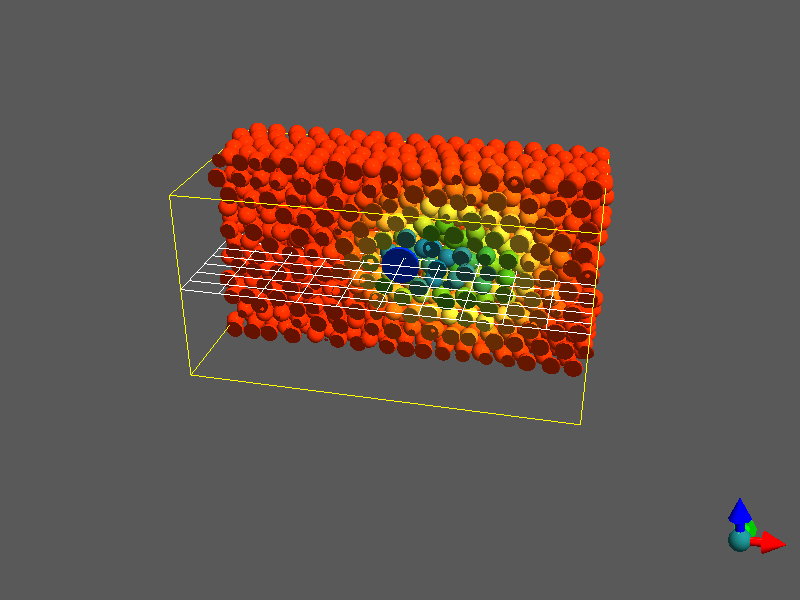

In [6]:
mx.ClipPlanes.create(mx.Universe.center, mx.MxVector3f(0, 1, 0))

mx.show()